## Реализация LSTM 

In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchmetrics import MeanSquaredError, R2Score
import time
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

### Готовим данные

In [56]:
market_data = pd.read_csv('C:/Projects/vsCode/ml_unik_project/data/market_project_data_usd.csv', sep=',')
market_data.tail()

,timestamp,btc_open,btc_high,btc_low,btc_close,btc_volume,btc_rsi,btc_macd,btc_macd_signal,btc_macd_hist,btc_slowK,btc_slowD,btc_atr,eth_open,eth_high,eth_low,eth_close,eth_volume,fear_greed,eth_rsi,eth_macd,eth_macd_signal,eth_macd_hist,eth_slowK,eth_slowD,eth_atr,fed_rate
29001,2024-10-28 06:00:00,67904.98,67960.84,67796.96,67960.84,2.126584e+07,61.089602,149.857681,161.277091,-11.419409,41.529205,34.515670,248.548729,2486.39,2491.58,2482.21,2491.58,1.699042e+07,72.0,51.240606,1.623511,3.403689,-1.780178,29.590458,24.128223,14.104938,4.83
29002,2024-10-28 07:00:00,67960.84,68687.24,67960.83,68422.86,6.663986e+07,70.811992,187.464076,166.514488,20.949588,58.815671,43.949671,282.681677,2491.58,2527.35,2490.85,2511.61,3.303710e+07,72.0,60.837478,3.122860,3.347523,-0.224663,44.538457,31.799753,15.704585,4.83
29003,2024-10-28 08:00:00,68422.86,68601.25,68319.72,68319.73,4.146691e+07,66.799715,206.564537,174.524498,32.040040,65.985977,55.443618,282.599414,2511.61,2521.34,2509.44,2513.00,1.957421e+07,72.0,61.405178,4.372858,3.552590,0.820268,60.173923,44.767613,15.432829,4.83
29004,2024-10-28 09:00:00,68319.73,68613.46,68234.50,68567.38,3.743416e+07,71.042774,238.930830,187.405764,51.525066,77.894878,67.565509,289.482313,2513.00,2542.71,2505.25,2542.04,2.804183e+07,72.0,70.897049,7.618949,4.365862,3.253087,81.255087,61.989156,17.006198,4.83
29005,2024-10-28 10:00:00,68567.38,68840.35,68540.79,68626.36,4.522336e+07,71.961822,266.271136,203.178838,63.092297,79.783399,74.554751,290.202148,2542.04,2545.04,2529.26,2531.14,2.580878e+07,72.0,64.486353,9.205842,5.333858,3.871984,84.599693,75.342901,16.918613,4.83


In [57]:
market_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29006 entries, 0 to 29005
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestamp        29006 non-null  object 
 1   btc_open         29006 non-null  float64
 2   btc_high         29006 non-null  float64
 3   btc_low          29006 non-null  float64
 4   btc_close        29006 non-null  float64
 5   btc_volume       29006 non-null  float64
 6   btc_rsi          29006 non-null  float64
 7   btc_macd         29006 non-null  float64
 8   btc_macd_signal  29006 non-null  float64
 9   btc_macd_hist    29006 non-null  float64
 10  btc_slowK        29006 non-null  float64
 11  btc_slowD        29006 non-null  float64
 12  btc_atr          29006 non-null  float64
 13  eth_open         29006 non-null  float64
 14  eth_high         29006 non-null  float64
 15  eth_low          29006 non-null  float64
 16  eth_close        29006 non-null  float64
 17  eth_volume  

#### Можем удалить timestamp, т.к. данные уже отсортированы

In [58]:
market_data = market_data.drop(['timestamp'], axis=1)
market_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29006 entries, 0 to 29005
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   btc_open         29006 non-null  float64
 1   btc_high         29006 non-null  float64
 2   btc_low          29006 non-null  float64
 3   btc_close        29006 non-null  float64
 4   btc_volume       29006 non-null  float64
 5   btc_rsi          29006 non-null  float64
 6   btc_macd         29006 non-null  float64
 7   btc_macd_signal  29006 non-null  float64
 8   btc_macd_hist    29006 non-null  float64
 9   btc_slowK        29006 non-null  float64
 10  btc_slowD        29006 non-null  float64
 11  btc_atr          29006 non-null  float64
 12  eth_open         29006 non-null  float64
 13  eth_high         29006 non-null  float64
 14  eth_low          29006 non-null  float64
 15  eth_close        29006 non-null  float64
 16  eth_volume       29006 non-null  float64
 17  fear_greed  

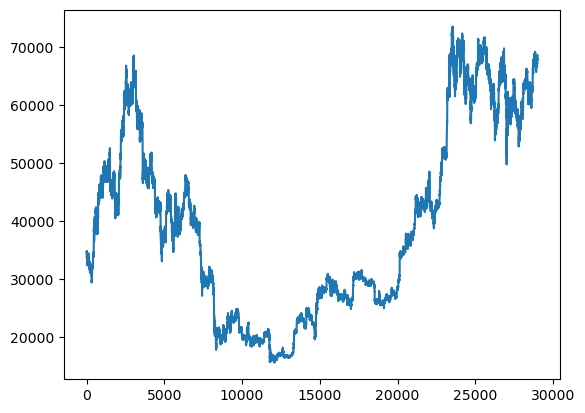

In [59]:
plt.plot(market_data['btc_close'])
plt.show()

#### train | validaton | test

In [60]:
train_size = int(0.75 * len(market_data))
#valid_size = int(0.15 * len(market_data))
test_size = len(market_data) - train_size 

train_data = market_data[:train_size]
#valid_data = market_data[train_size : train_size + valid_size]
test_data = market_data[train_size:]

print('size of train df: ', train_data.shape)
#print('size of valid df: ', valid_data.shape)
print('size of test df: ', test_data.shape)

size of train df:  (21754, 26)
size of test df:  (7252, 26)


#### Нормализация MixMaxScaler()

In [61]:
y_col = 'btc_close'
X_cols = [col for col in train_data.columns if col != y_col]

train_data = train_data.copy()
#valid_data = valid_data.copy()
test_data = test_data.copy()

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

train_data[X_cols] = scaler_X.fit_transform(train_data[X_cols])
train_data[y_col] = scaler_y.fit_transform(train_data[[y_col]])

#valid_data[X_cols] = scaler_X.transform(valid_data[X_cols])
#valid_data[y_col] = scaler_y.transform(valid_data[[y_col]])

test_data[X_cols] = scaler_X.transform(test_data[X_cols])
test_data[y_col] = scaler_y.transform(test_data[[y_col]])

In [62]:
test_data.tail()

,btc_open,btc_high,btc_low,btc_close,btc_volume,btc_rsi,btc_macd,btc_macd_signal,btc_macd_hist,btc_slowK,btc_slowD,btc_atr,eth_open,eth_high,eth_low,eth_close,eth_volume,fear_greed,eth_rsi,eth_macd,eth_macd_signal,eth_macd_hist,eth_slowK,eth_slowD,eth_atr,fed_rate
29001,0.987301,0.981082,0.987947,0.988357,0.077967,0.641721,0.689794,0.692881,0.598078,0.403437,0.337257,0.166073,0.401363,0.397379,0.405253,0.402680,0.112719,0.846154,0.526295,0.619930,0.631782,0.604254,0.278552,0.215435,0.111974,0.904762
29002,0.988357,0.994737,0.991042,0.997087,0.244330,0.753902,0.700216,0.694515,0.626393,0.580578,0.436954,0.190260,0.402680,0.406466,0.407440,0.407762,0.219178,0.846154,0.636032,0.625948,0.631533,0.619878,0.432272,0.295510,0.126300,0.904762
29003,0.997087,0.993121,0.997819,0.995139,0.152034,0.707606,0.705509,0.697014,0.636095,0.654055,0.558421,0.190201,0.407762,0.404939,0.412144,0.408114,0.129861,0.846154,0.642523,0.630965,0.632444,0.630373,0.593061,0.430866,0.123866,0.904762
29004,0.995139,0.993350,0.996210,0.999818,0.137248,0.756564,0.714478,0.701034,0.653140,0.776091,0.686523,0.195079,0.408114,0.410368,0.411084,0.415482,0.186038,0.846154,0.751060,0.643992,0.636060,0.654808,0.809851,0.610623,0.137956,0.904762
29005,0.999818,0.997615,1.001994,1.000933,0.165807,0.767169,0.722055,0.705956,0.663258,0.795443,0.760385,0.195589,0.415482,0.410959,0.417160,0.412717,0.171223,0.846154,0.677756,0.650361,0.640364,0.661025,0.844246,0.750007,0.137172,0.904762


#### Создание временных окон

In [63]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, target_column, sequence_length=24):
        self.data = data
        self.target_column = target_column
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        X = self.data.iloc[idx:idx + self.sequence_length].drop(columns=[self.target_column]).values
        
        y = self.data.iloc[idx + self.sequence_length][self.target_column]
        
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [64]:
sequence_length = 24
target_column = 'eth_close'  

train_dataset = TimeSeriesDataset(train_data, target_column, sequence_length)
#val_dataset = TimeSeriesDataset(valid_data, target_column, sequence_length)
test_dataset = TimeSeriesDataset(test_data, target_column, sequence_length)

X, y = train_dataset[0]
print(f"X shape: {X.shape}, y shape: {y}")
print("len train: ", len(train_dataset))

X shape: torch.Size([24, 25]), y shape: 0.37007221579551697
len train:  21730


In [65]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
#val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
    print(f"batch {batch_idx}| shape X: {x_batch.shape}, shape y: {y_batch.shape}")
    break

batch 0| shape X: torch.Size([32, 24, 25]), shape y: torch.Size([32])


### Строим модель

In [66]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(f"device: {device}")

device: cuda


In [67]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, fc_size, output_size, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        
        # 1st LSTM
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # 2nd LSTM
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Linears
        self.fc1 = nn.Linear(hidden_size2, fc_size)  
        self.sigmoid = nn.Sigmoid()  
        self.fc2 = nn.Linear(fc_size, output_size)  
        
    
    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        
        out, _ = self.lstm2(out)
        out = self.dropout2(out)

        out = out[:, -1, :]  
        
        out = self.fc1(out)  
        out = self.sigmoid(out)  
        out = self.fc2(out)  
        
        return out

In [68]:
input_size = 25   
hidden_size1 = 48  
hidden_size2 = 24  
fc_size = 16      
output_size = 1     
dropout_rate = 0.4
num_epochs = 50
learning_rate = 0.001

model = LSTMModel(input_size, hidden_size1, hidden_size2, fc_size, output_size, dropout_rate).to(device)
print(model)

LSTMModel(
  (lstm1): LSTM(25, 64, batch_first=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (lstm2): LSTM(64, 32, batch_first=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)


In [69]:
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [70]:
X_example = torch.rand(BATCH_SIZE, sequence_length, input_size).to(device)

y_pred = model(X_example)
print(f"output shape: {y_pred.shape}")  

output shape: torch.Size([32, 1])


### Обучаем модель

In [71]:
def train_model(model_nn, train_loader, test_loader, optimizer, loss_fn, num_epochs, device):
    train_r2 = R2Score().to(device)
    test_r2 = R2Score().to(device)
    
    for epoch in range(num_epochs):
        start = time.time()
        
        train_loss = 0.0
        train_iters = 0
        
        model_nn.train()
        
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)  
            y = y.unsqueeze(-1)  
            
            y_pred = model_nn(X)  
            
            optimizer.zero_grad()  
            loss = loss_fn(y_pred, y)  
            loss.backward()  
            optimizer.step()  
            
            train_loss += loss.item()  
            train_iters += 1
            
            train_r2.update(y_pred, y)
        
        train_r2_out = train_r2.compute()
        train_r2.reset()

        test_loss = 0.0
        test_iters = 0
        
        model_nn.eval()
        
        with torch.no_grad():  
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)  
                y = y.unsqueeze(-1)  
                
                y_pred = model_nn(X)  
                
                loss = loss_fn(y_pred, y)  
                
                test_loss += loss.item()  
                test_iters += 1
                
                test_r2.update(y_pred, y)
        
        test_r2_out = test_r2.compute()
        test_r2.reset()

        if (epoch < 9):
            print(f"Эпоха: 0{epoch+1} | Время: {time.time()-start:.2f} сек | "
              f"Train Loss: {train_loss/train_iters:.4f} | Train R²: {train_r2_out:.2f} | "
              f"Test Loss: {test_loss/test_iters:.4f} | Test R²: {test_r2_out:.2f}")
        else:
            print(f"Эпоха: {epoch+1} | Время: {time.time()-start:.2f} сек | "
                f"Train Loss: {train_loss/train_iters:.4f} | Train R²: {train_r2_out:.2f} | "
                f"Test Loss: {test_loss/test_iters:.4f} | Test R²: {test_r2_out:.2f}")


In [72]:
train_model(model, train_loader, test_loader, optimizer, loss_fn, num_epochs, device)

Эпоха: 01 | Время: 15.66 сек | Train Loss: 0.0058 | Train R²: 0.89 | Test Loss: 0.0452 | Test R²: -1.79
Эпоха: 02 | Время: 15.08 сек | Train Loss: 0.0059 | Train R²: 0.89 | Test Loss: 0.0456 | Test R²: -1.81
Эпоха: 03 | Время: 15.77 сек | Train Loss: 0.0059 | Train R²: 0.88 | Test Loss: 0.0456 | Test R²: -1.81
Эпоха: 04 | Время: 16.20 сек | Train Loss: 0.0060 | Train R²: 0.88 | Test Loss: 0.0457 | Test R²: -1.81
Эпоха: 05 | Время: 15.96 сек | Train Loss: 0.0059 | Train R²: 0.88 | Test Loss: 0.0455 | Test R²: -1.80
Эпоха: 06 | Время: 15.95 сек | Train Loss: 0.0055 | Train R²: 0.89 | Test Loss: 0.0457 | Test R²: -1.81
Эпоха: 07 | Время: 16.19 сек | Train Loss: 0.0053 | Train R²: 0.90 | Test Loss: 0.0467 | Test R²: -1.88
Эпоха: 08 | Время: 16.60 сек | Train Loss: 0.0039 | Train R²: 0.92 | Test Loss: 0.0493 | Test R²: -2.04
Эпоха: 09 | Время: 16.58 сек | Train Loss: 0.0029 | Train R²: 0.94 | Test Loss: 0.0485 | Test R²: -1.99
Эпоха: 10 | Время: 15.91 сек | Train Loss: 0.0028 | Train R²: 0.